# GMM: Probabilistic Generative Model


GMM is a probabilistic generative model.

A Generative Model is a powerful way of learning data distribution using unsupervised learning. Generative models aim at learning the true data distribution of the training set so as to generate new data points with some variations. 

In this notebook we explore the data generation aspect of GMM.

GMM is a clustering technique. However, it works well only when data distribution is Gaussian. In scenarios when data is non-Gaussian, GMM can be used to characterize the distribution of the entire dataset. Then, we can generate new samples that mimic the original underlying data!



## Data Generation Process of GMM

For each $\vec x_n, n = 1, 2, ..., N$:

- First choose one of the $K$ mixture components as

$\vec z_n \sim Multinomial(\vec z_n | \pi)$ (from prior $p(\vec z)$ over $\vec z$)

- Suppose $\vec z_n = k$. Now generate $\vec x_n$ from the $k$-th Gaussian as

$\vec x_n \sim \mathcal{N}(\vec x_n | \vec \mu_n, \vec \Sigma_k)$ (from the data distribution $p(\vec x | \vec z)$)



<img src="https://cse.unl.edu/~hasan/Pics/GMM-GenerativeModel.png" width=800, height=400>



## Tasks

To demonstrate the generative prowess of GMM, we will use a non-Gaussian dataset that contains multiple clusters.

As noted earlier, due to the non-Gaussian nature of data distribution, GMM would be unable to discover the actual clusters.

However, it would be good at learning the dataset to indentify regions of high-density in the sample space. We can use this model to generate data that matches with the original distribution.


In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.datasets import make_moons
from sklearn.mixture import GaussianMixture


# Synthetic Dataset

To create non-gaussian clusters we use Scikit-Learn's "datasets.make_moons" function.

Following parameter is used by the make_moons function:

- noise : Standard deviation of Gaussian noise added to the data.

Using the make_moons function we will create **two clusters** of points.

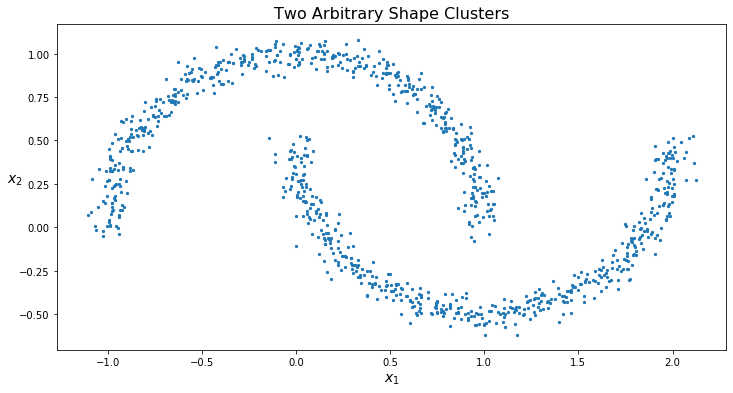

In [2]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)


plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=None, s=5, cmap='autumn')
plt.title("Two Arbitrary Shape Clusters", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

## GMM

Since we have two clusters in the non-Gaussian dataset, we set k = 2 in the GMM model.

Our goal is to see whether GMM is able to identify these two clusters.

In [3]:
gmm = GaussianMixture(n_components=2, n_init=10, random_state=42)
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=2, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

## Observation

We see that due to the non-Gaussian nature of the data distribution, GMM is unable to identify the two clusters.

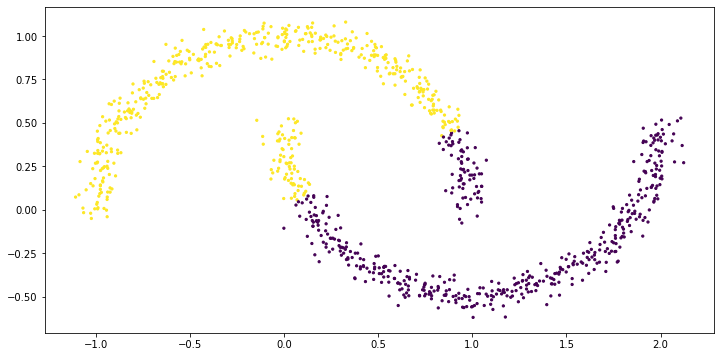

In [4]:
labels = gmm.predict(X)

plt.figure(figsize=(12, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=5, cmap='viridis');

## Generative Process of GMM

To demonstrate the data generation process of GMM, we need to use an optimal value of $k$ to train the GMM.

We train the GMM model with various values of $k$ and measure their Bayesian information criterion (BIC) and the Akaike information criterion (AIC).

The AIC seems to decrease continuously. Thus, we use BIC to choose the optimal model.

The minimum BIC indicates that there are 12 clusters.

Thus, we choose the optimal $k = 12$ to train the GMM.

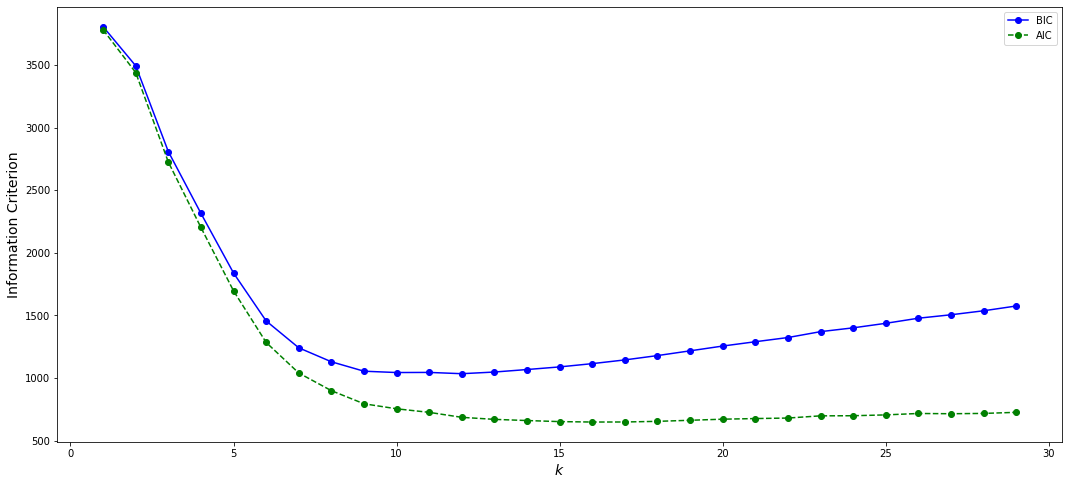

In [5]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 30)]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(18, 8))
plt.plot(range(1, 30), bics, "bo-", label="BIC")
plt.plot(range(1, 30), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.legend()

plt.show()


## Train a Model using the Optimal $k$ Obtained from the Lowest BIC

We train a GMM using optimal $k$ from the lowest BIC.

In [6]:
gmm2 = GaussianMixture(n_components=12, n_init=10, random_state=42)
gmm2.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=12, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

## Plot the Clusters & Density Regions

To visualize the density contours created by the GMM model, we use the following functions.

It also shows the cluster means and the decision boundaries (using dashed lines).

In [7]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

## Plot Anomalies

/Users/hasan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Log scale: values of z <= 0 have been masked
/Users/hasan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Log scale: values of z <= 0 have been masked


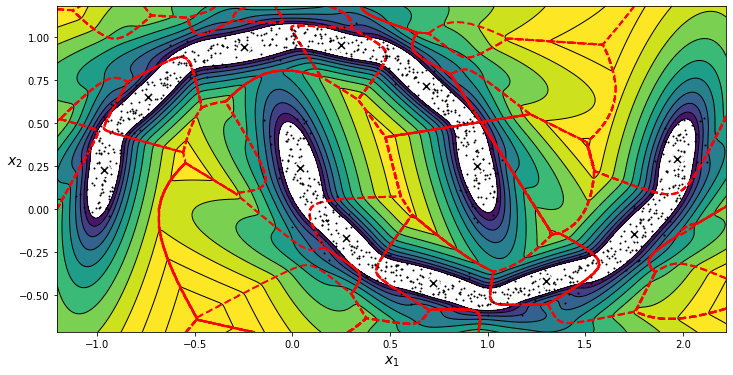

In [8]:
plt.figure(figsize=(12, 6))

plot_gaussian_mixture(gmm2, X)

plt.show()

## Observation

We see that the shape and area of high-density regions match with the two clusters.

In other words, according to our GMM, the likelihood of the data is the highest in the two clusters.

However, the high-density regions are comprised of many Gaussians. The collection of clusters has fit the data set reasonably well. 

Now to determine if the model has actually learned about this dataset, we will create entirely new samples.

Then, we will see if those samples look like the original distribution.

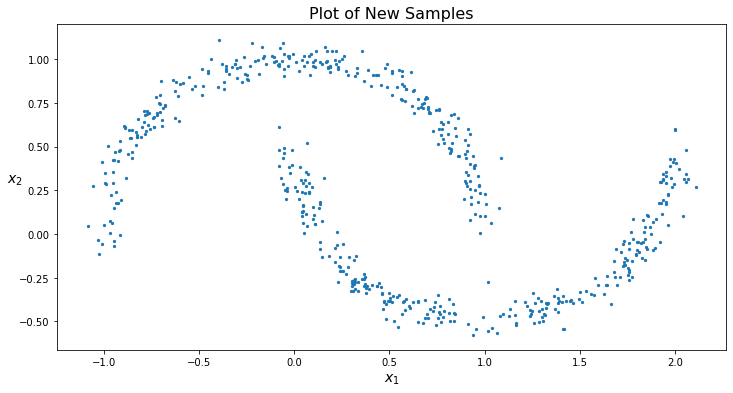

In [9]:
X_new, y_new = gmm2.sample(600)

plt.figure(figsize=(12, 6))
plt.scatter(X_new[:, 0], X_new[:, 1], c=None, s=5, cmap='autumn')
plt.title("Plot of New Samples", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

## Observation

We see that the new samples are generated from the areas of two clusters of original distribution.